In [1]:
%cd "~/Projects/Segmentation/TreeSeg"
import json
from pathlib import Path
import time
import math
from typing import Union
import os
import numpy as np
import torch
from torch import Tensor
from tqdm import tqdm
import nvdiffrast.torch as dr
import matplotlib.pyplot as plt
import tree_segmentation as ts
from semantic_sam import semantic_sam_l
import torch_geometric as pyg
from tree_segmentation.extension import Mesh, ops_3d, utils
from tree_segmentation import TreeData, Tree3Dv2, Tree3D
import open3d as o3d
import struct

/home/wan/Projects/Segmentation/TreeSeg
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


2023-07-28 22:06:22.527488: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-28 22:06:23.589262: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/wan/miniconda3/envs/wan/lib/python3.8/site-packages/cv2/../../lib64:/usr/local/cuda-11.7/lib64:/usr/local/cuda-11.7/lib64:/usr/local/cuda-11.7/lib64:/usr/local/cuda-11.7/lib64:/usr/local/cuda-11.7/lib64:
2023-07-28 22:06:23.589402: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so

In [2]:
print(torch.__version__)
%load_ext autoreload
%autoreload 2
%matplotlib inline
device = torch.device('cuda')
torch.set_grad_enabled(False)
glctx = dr.RasterizeCudaContext()

2.0.1+cu117


In [3]:
data_root = Path('~/data/Replica').expanduser().resolve()
data_dir = data_root.joinpath('room_1')
print('data direcotry:', data_dir)
mesh_path = data_dir.joinpath('mesh.ply')
cache_dir = Path(f'./results/{ts.get_hash_name(mesh_path)}')
print('cache dir:', cache_dir)

data direcotry: /data5/Replica/room_1
cache dir: results/dfa19da2d68639883ce9f71be79210a5


In [11]:
cache_file = cache_dir.joinpath(mesh_path.name).with_suffix('.mesh_cache')
if cache_file.exists() and 0:
    mesh = torch.load(cache_file, map_location=device)  # type: Mesh
else:
    mesh = Mesh.load(mesh_path)
    mesh.float()
    mesh.int()
    # mesh = mesh.unit_size()
    # mesh_ = mesh.to_open3d()
    # print(mesh_)
    # mesh_smp = mesh_.simplify_quadric_decimation(target_number_of_triangles=100_000, maximum_error=0.1)
    # mesh_smp = mesh_.simplify_vertex_clustering(target_number_of_triangles=500_000, maximum_error=0.5)
    # o3d.io.write_triangle_mesh(cache_dir.joinpath('simplified.ply').as_posix(), mesh_smp)
    # mesh = mesh.from_open3d(mesh_smp).cuda().unit_size()
    # print(mesh)
    mesh = mesh.cuda().unit_size()
    cache_dir.mkdir(exist_ok=True)
    torch.save(mesh, cache_file)
    print('save cached mesh to', cache_file)
print(mesh)

<class 'numpy.ndarray'> (645078, 4)
[[0 1 2 3]
 [2 1 0 4]
 [2 5 6 3]
 [7 8 0 3]]
[[0 1 2]
 [0 2 3]
 [2 1 0]
 [2 0 4]
 [2 5 6]
 [2 6 3]
 [7 8 0]
 [7 0 3]]
save cached mesh to results/dfa19da2d68639883ce9f71be79210a5/mesh.mesh_cache
Mesh(vertices=645512, faces=1290156, clr, nrm)


In [10]:
semantic_mesh_path = data_dir.joinpath('habitat/mesh_semantic.ply')
assert semantic_mesh_path.exists()
semantic_data = utils.parse_ply(semantic_mesh_path)
print(utils.show_shape(semantic_data))
assert semantic_data[1]['name'] == 'face' and semantic_data[1]['names'][1] == 'object_id'
semantic_label = semantic_data[1]['data'][1]  # type: np.ndarray
semantic_label = np.repeat(semantic_label[:, None], semantic_data[1]['data'][0].shape[1] - 2, axis=1).reshape(-1)
print(semantic_label[:10])
print('semantic_label', utils.show_shape(semantic_label))
N_max = np.max(semantic_label) + 1
gt = Tree3Dv2(mesh, device=device)
gt.masks = torch.zeros((N_max, gt.num_faces + 1), device=device, dtype=torch.bool)
gt.scores = torch.ones((N_max,), device=device)
gt.resize(N_max + 1)
for i in range(N_max):
    gt.node_insert(gt.node_new(), 0)
    gt.masks[i, 1:] = torch.from_numpy(semantic_label == i).to(device)
gt.print_tree()
gt.save(cache_dir.joinpath('gt.tree3dv2'))

[{'name': 'vertex', 'num': 645512, 'dtypes': ['float', 'float', 'float', 'float', 'float', 'float', 'uchar', 'uchar', 'uchar'], 'names': ['x', 'y', 'z', 'nx', 'ny', 'nz', 'red', 'green', 'blue'], 'all_scalar': True, 'data': [numpy((645512,), float32), numpy((645512,), float32), numpy((645512,), float32), numpy((645512,), float32), numpy((645512,), float32), numpy((645512,), float32), numpy((645512,), uint8), numpy((645512,), uint8), numpy((645512,), uint8)]}, {'name': 'face', 'num': 645078, 'dtypes': [('uint8', 'uint32'), 'uint16'], 'names': ['vertex_indices', 'object_id'], 'all_scalar': False, 'data': [numpy((645078, 4), uint32), numpy((645078,), uint16)]}]
[ 1  1 20 20  0  0 20 20 20 20]
semantic_label numpy((1290156,), uint16)


0: Tree Root
├── 57
├── 56
├── 55
├── 54
├── 53
├── 52
├── 51
├── 50
├── 49
├── 48
├── 47
├── 46
├── 45
├── 44
├── 43
├── 42
├── 41
├── 40
├── 39
├── 38
├── 37
├── 36
├── 35
├── 34
├── 33
├── 32
├── 31
├── 30
├── 29
├── 28
├── 27
├── 26
├── 25
├── 24
├── 23
├── 22
├── 21
├── 20
├── 19
├── 18
├── 17
├── 16
├── 15
├── 14
├── 13
├── 12
├── 11
├── 10
├── 9
├── 8
├── 7
├── 6
├── 5
├── 4
├── 3
├── 2
└── 1

[Tree3D] Save results to results/dfa19da2d68639883ce9f71be79210a5/gt.tree3dv2


In [18]:
print(np.unique(semantic_label))
print(semantic_label[:10])
print(semantic_label[-10:])

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56]
[ 1  1 20 20  0  0 20 20 20 20]
[42 42 42 42 42 42 42 42 42 42]


In [27]:
with data_dir.joinpath('semantic.bin').open('rb') as f:
    labels = np.array(list(struct.iter_unpack('@Q', f.read())), dtype=np.uint64).astype(np.int32)
    print(labels.shape, labels.dtype)
    assert 0 <= labels.min() and labels.max() < mesh.f_pos.shape[0] // 2
with data_dir.joinpath('semantic.json').open('r') as f:
    semantic_info = json.load(f)
print(list(semantic_info.keys()))
children = []
parent = []
names = []
numPrimitives = []
for obj in semantic_info['segmentation']:
    idx = obj['id']
    while len(children) <= idx:
        children.append([])
        parent.append(-1)
        names.append([''])
        numPrimitives.append(0)
    parent[idx] = -1 if obj['parent'] == '' else int(obj['parent'])
    children[idx] = [int(c) for c in obj['children']]
    names[idx] = obj['class']
    numPrimitives[idx] = obj['numPrimitives']
    if len(obj['children']) > 0:
        assert obj['numPrimitives'] == 0
numPrimitives = np.array(numPrimitives)
print(numPrimitives.shape, numPrimitives.dtype)
prefix_sum = np.cumsum(numPrimitives) - numPrimitives
print(prefix_sum[:10], numPrimitives[:10])
for i in range(len(children)):
    for c in children[i]:
        assert parent[c] == i

from rich.console import Console
from rich.tree import Tree

gt = Tree3D(mesh, device=device)
gt.resize(len(children) + 1)


def _make_tree(p, tree_idx, tree_: Tree):
    for c in children[p]:
        ci = gt.node_new()
        gt.node_insert(ci, tree_idx)
        _make_tree(c, ci, tree_.add(f'{names[c]}_{c}'))
    if len(children[p]) == 0:
        s = prefix_sum[p]
        e = s + numPrimitives[p]
        for i in range(s, e):
            gt.face_parent[labels[i] * 2 + 1] = tree_idx
            gt.face_parent[labels[i] * 2 + 2] = tree_idx


console = Console()
show_tree = Tree('root')
for i in range(len(parent)):
    if parent[i] == -1:
        idx = gt.node_new()
        gt.node_insert(idx, 0)
        _make_tree(i, idx, show_tree.add(f'{names[i]}_{i}'))
# console.print(show_tree)
gt.print_tree()
gt.save(cache_dir.joinpath('gt.tree3d'))
gt_v2 = Tree3Dv2.convert(gt)
gt_v2.save(cache_dir.joinpath('gt.tree3dv2'))

(644793, 1) int32
['dataset', 'gravityCenter', 'gravityDirection', 'idType', 'meta', 'segmentation', 'segmentationFile', 'version']
(561,) int64
[   0 4150 4154 8328 8328 8328 8328 8330 8330 8375] [4150    4 4174    0    0    0    2    0   45    0]
[Tree] reset
[Tree] Resize tree from 1 to 562


0: Tree Root
├── 509
│   ├── 561
│   ├── 560
│   ├── 559
│   ├── 558
│   ├── 557
│   ├── 556
│   ├── 555
│   ├── 554
│   ├── 553
│   ├── 552
│   ├── 551
│   ├── 550
│   ├── 549
│   ├── 548
│   ├── 547
│   ├── 546
│   ├── 545
│   ├── 544
│   ├── 543
│   ├── 542
│   ├── 541
│   ├── 540
│   ├── 539
│   ├── 538
│   ├── 537
│   ├── 536
│   ├── 535
│   ├── 534
│   ├── 533
│   ├── 532
│   ├── 531
│   ├── 530
│   ├── 529
│   ├── 528
│   ├── 527
│   ├── 526
│   ├── 525
│   ├── 524
│   ├── 523
│   ├── 522
│   ├── 521
│   ├── 520
│   ├── 519
│   ├── 518
│   ├── 517
│   ├── 516
│   ├── 515
│   ├── 514
│   ├── 513
│   ├── 512
│   ├── 511
│   └── 510
├── 443
│   ├── 508
│   ├── 507
│   ├── 506
│   ├── 505
│   ├── 504
│   ├── 503
│   ├── 502
│   ├── 501
│   ├── 500
│   ├── 499
│   ├── 498
│   ├── 497
│   ├── 496
│   ├── 495
│   ├── 494
│   ├── 493
│   ├── 492
│   ├── 491
│   ├── 490
│   ├── 489
│   ├── 488
│   ├── 487
│   ├── 486
│   ├── 485
│   ├── 484
│   ├── 483
│   ├── 482
│   ├── 481
│   ├── 480
│   ├── 479
│   ├── 478
│   ├── 477
│   ├── 476
│   ├── 475
│   ├── 474
│   ├── 473
│   ├── 472
│   ├── 471
│   ├── 470
│   ├── 469
│   ├── 468
│   ├── 467
│   ├── 466
│   ├── 465
│   ├── 464
│   ├── 463
│   ├── 462
│   ├── 461
│   ├── 460
│   ├── 459
│   ├── 458
│   ├── 457
│   ├── 456
│   ├── 455
│   ├── 454
│   ├── 453
│   ├── 452
│   ├── 451
│   ├── 450
│   ├── 449
│   ├── 448
│   ├── 447
│   ├── 446
│   ├── 445
│   └── 444
├── 435
│   ├── 442
│   ├── 441
│   ├── 440
│   ├── 439
│   ├── 438
│   ├── 437
│   └── 436
├── 418
│   ├── 434
│   ├── 433
│   ├── 432
│   ├── 431
│   ├── 430
│   ├── 429
│   ├── 428
│   ├── 427
│   ├── 426
│   ├── 425
│   ├── 424
│   ├── 423
│   ├── 422
│   ├── 421
│   ├── 420
│   └── 419
├── 412
│   ├── 417
│   ├── 416
│   ├── 415
│   ├── 414
│   └── 413
├── 401
│   ├── 411
│   ├── 410
│   ├── 409
│   ├── 408
│   ├── 407
│   ├── 406
│   ├── 405
│   ├── 404
│   ├── 403
│   └── 402
├── 350
│   ├── 400
│   ├── 399
│   ├── 398
│   ├── 397
│   ├── 396
│   ├── 395
│   ├── 394
│   ├── 393
│   ├── 392
│   ├── 391
│   ├── 390
│   ├── 389
│   ├── 388
│   ├── 387
│   ├── 386
│   ├── 385
│   ├── 384
│   ├── 383
│   ├── 382
│   ├── 381
│   ├── 380
│   ├── 379
│   ├── 378
│   ├── 377
│   ├── 376
│   ├── 375
│   ├── 374
│   ├── 373
│   ├── 372
│   ├── 371
│   ├── 370
│   ├── 369
│   ├── 368
│   ├── 367
│   ├── 366
│   ├── 365
│   ├── 364
│   ├── 363
│   ├── 362
│   ├── 361
│   ├── 360
│   ├── 359
│   ├── 358
│   ├── 357
│   ├── 356
│   ├── 355
│   ├── 354
│   ├── 353
│   ├── 352
│   └── 351
├── 335
│   ├── 349
│   ├── 348
│   ├── 347
│   ├── 346
│   ├── 345
│   ├── 344
│   ├── 343
│   ├── 342
│   ├── 341
│   ├── 340
│   ├── 339
│   ├── 338
│   ├── 337
│   └── 336
├── 324
│   ├── 334
│   ├── 333
│   ├── 332
│   ├── 331
│   ├── 330
│   ├── 329
│   ├── 328
│   ├── 327
│   ├── 326
│   └── 325
├── 322
│   └── 323
├── 320
│   └── 321
├── 318
│   └── 319
├── 310
│   ├── 317
│   ├── 316
│   ├── 315
│   ├── 314
│   ├── 313
│   ├── 312
│   └── 311
├── 303
│   ├── 309
│   ├── 308
│   ├── 307
│   ├── 306
│   ├── 305
│   └── 304
├── 286
│   ├── 302
│   ├── 301
│   ├── 300
│   ├── 299
│   ├── 298
│   ├── 297
│   ├── 296
│   ├── 295
│   ├── 294
│   ├── 293
│   ├── 292
│   ├── 291
│   ├── 290
│   ├── 289
│   ├── 288
│   └── 287
├── 277
│   ├── 285
│   ├── 284
│   ├── 283
│   ├── 282
│   ├── 281
│   ├── 280
│   ├── 279
│   └── 278
├── 269
│   ├── 276
│   ├── 275
│   ├── 274
│   ├── 273
│   ├── 272
│   ├── 271
│   └── 270
├── 262
│   ├── 268
│   ├── 267
│   ├── 266
│   ├── 265
│   ├── 264
│   └── 263
├── 252
│   ├── 261
│   ├── 260
│   ├── 259
│   ├── 258
│   ├── 257
│   ├── 256
│   ├── 255
│   ├── 254
│   └── 253
├── 242
│   ├── 251
│   ├── 250
│   ├── 249
│   ├── 248
│   ├── 247
│   ├── 246
│   ├── 245
│   ├── 244
│   └── 243
├── 237
│   ├── 241
│   ├── 240
│   ├── 239
│   └── 238
├── 232
│   ├── 236
│   ├── 235
│   ├── 234
│   └── 233
├── 177
│   ├── 231
│   ├── 230
│   ├── 229
│   ├── 228
│   ├── 227
│   ├── 226
│   ├── 225
│   ├── 224
│   ├── 223

[Tree3D]save now Tree3D to results/dfa19da2d68639883ce9f71be79210a5/gt.tree3d
[Tree] reset
[Tree] reset
[Tree] Resize tree from 1 to 561
[Tree] rerange nodes
[Tree3D] Save results to results/dfa19da2d68639883ce9f71be79210a5/gt.tree3dv2


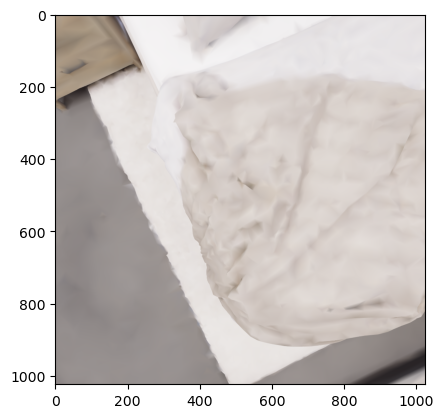

In [5]:
fovy = math.radians(90)
image_size = 1024
Tv2c = ops_3d.perspective(fovy=fovy, size=(image_size, image_size)).to(device)
Tw2v = torch.eye(4, device=device)
image, tri_id = ts.render_mesh(glctx, mesh, Tw2v=Tw2v, fovy=fovy, image_size=image_size)
plt.imshow(image.cpu().numpy())

In [6]:
# min_max = mesh.AABB
# print('mesh bounding box:', min_max.tolist())
# min_max = min_max * 0.9
# min_distance = 0.05
# xyz = torch.rand((N, 3), device=device) * (min_max[1] - min_max[0]) + min_max[0]
# print(utils.show_shape(xyz), xyz.aminmax(dim=0))
N = 100
phi_range = [0, math.pi * 2.]
cos_theta_range = [math.cos(0), math.cos(math.pi)]
phis = torch.rand((N,), device=device) * (phi_range[1] - phi_range[0]) + phi_range[0]
thetas = torch.arccos(torch.rand((N,), device=device) * (cos_theta_range[1] - cos_theta_range[0]) + cos_theta_range[0])
radius = torch.zeros((N,), device=device)
at = ops_3d.coord_spherical_to(radius, thetas, phis).to(device)
Tw2vs = ops_3d.look_at(at, torch.zeros_like(at))
print(utils.show_shape(Tw2vs))

F32Tensor[100, 4, 4]


In [7]:
"""球面上的均匀格点"""
N = 100
seq = torch.arange(N, device=device)
c = (math.sqrt(5) - 1) * math.pi
z = ((seq * 2 - 1) / N - 1).clamp(-1, 1)
x = torch.sqrt(1 - z * z) * (seq * c).cos()
y = torch.sqrt(1 - z * z) * (seq * c).sin()
at = torch.stack([x, y, z], dim=-1)
at = at * (torch.ones((N, 1), device=device))  # * (radius_range[1] - radius_range[0]) + radius_range[0])
Tw2vs = ops_3d.look_at(torch.zeros_like(at), at)
print(utils.show_shape(Tw2vs), Tw2vs[1])

F32Tensor[100, 4, 4] tensor([[ 0.9945,  0.0000, -0.1045,  0.0000],
        [-0.0100,  0.9954, -0.0948,  0.0000],
        [ 0.1040,  0.0953,  0.9900,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  1.0000]], device='cuda:0')


F32Tensor[100, 1024, 1024, 3], IntTensor[100, 1024, 1024]


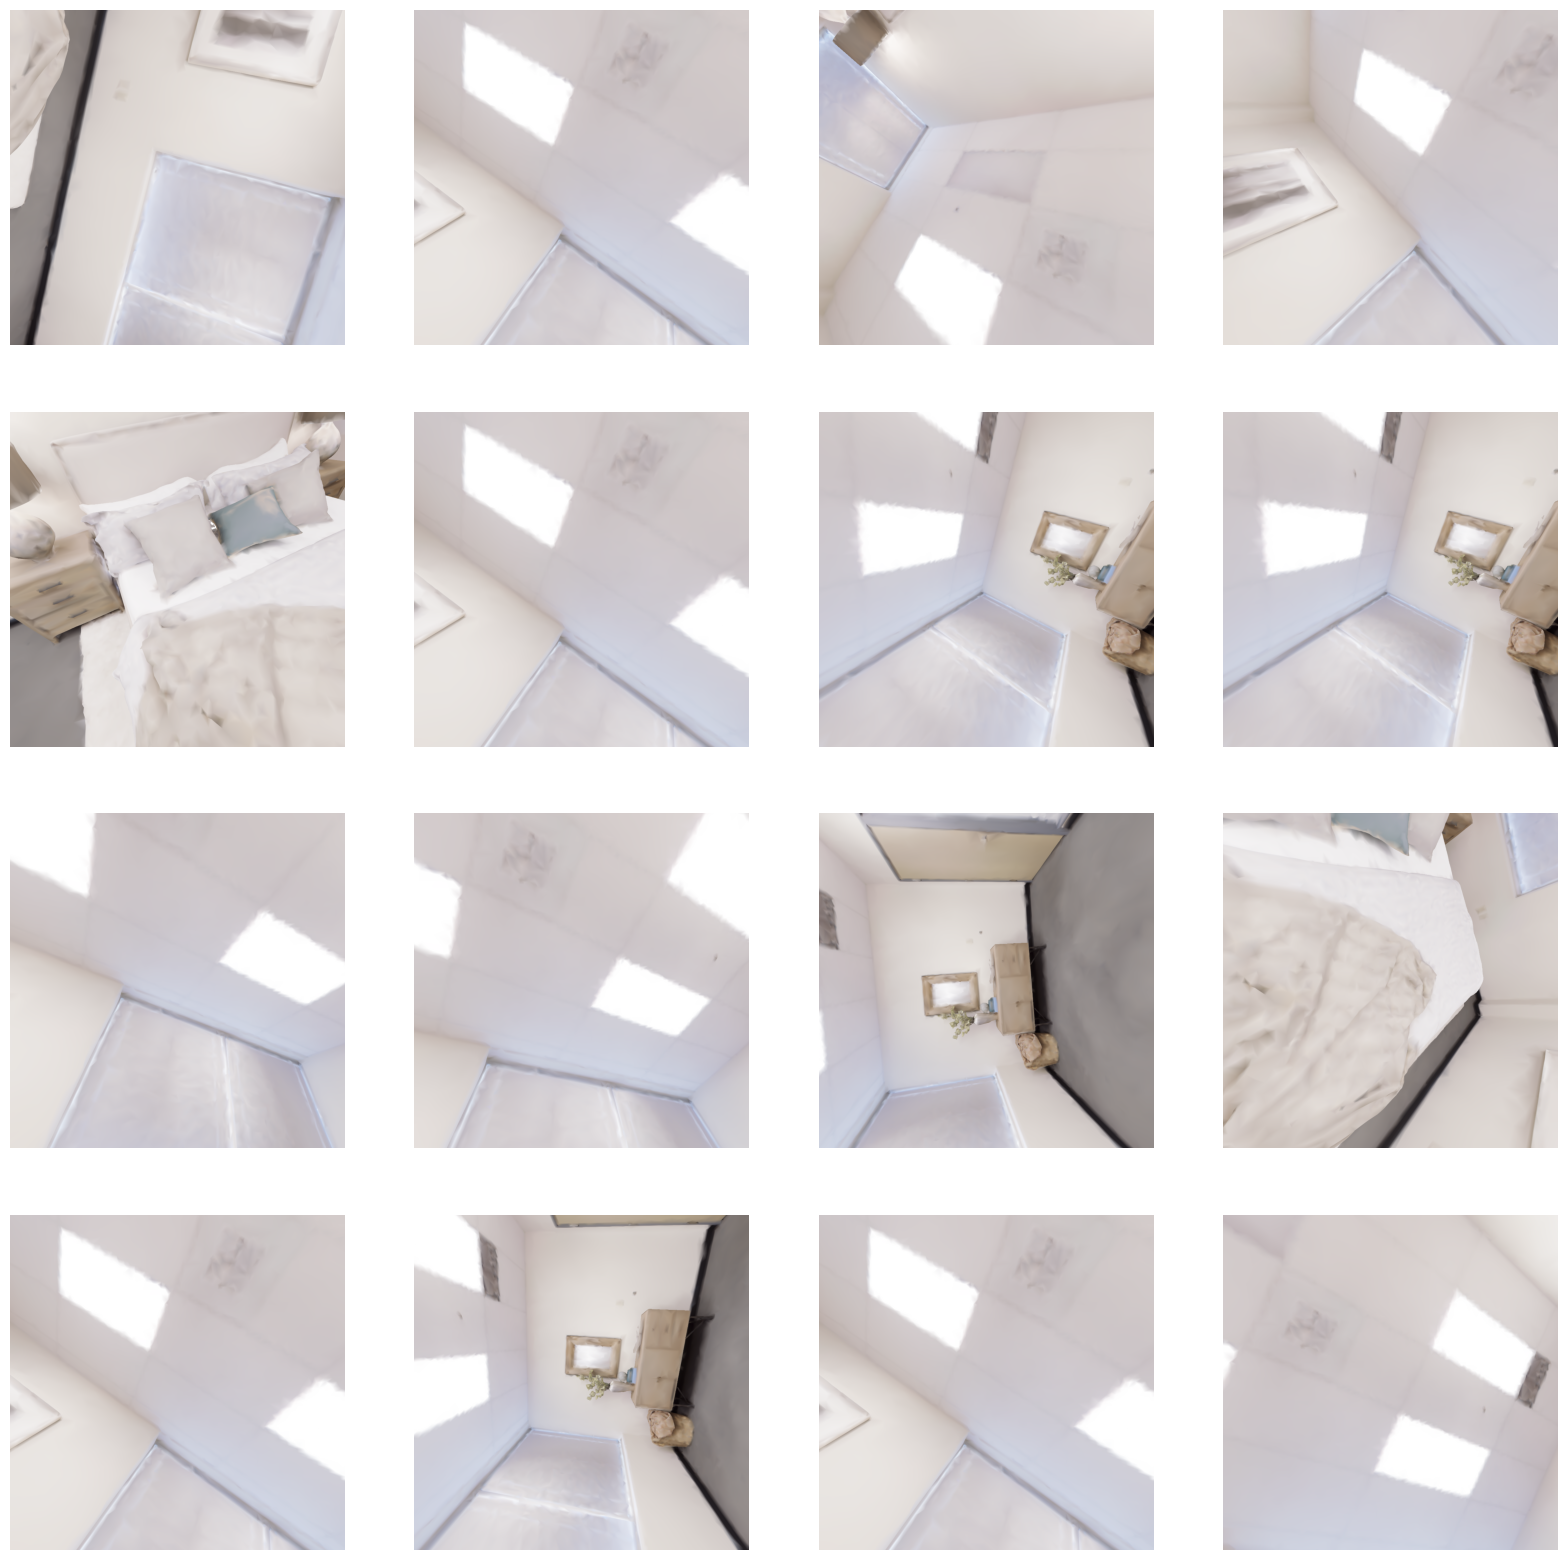

In [8]:
images, tri_ids = [], []
for i in range(0, N, 10):
    images_i, tri_ids_i = ts.render_mesh(
        glctx,
        mesh,
        Tw2v=Tw2vs[i:i + 10],
        image_size=image_size,
        fovy=math.radians(90)
    )
    images.append(images_i.cpu())
    tri_ids.append(tri_ids_i.cpu())
images, tri_ids = torch.cat(images), torch.cat(tri_ids)
print(utils.show_shape(images, tri_ids))
plt.figure(figsize=(20, 20))
for i in range(min(16, images.shape[0])):
    plt.subplot(4, 4, i + 1)
    # plt.imshow(images[i].cpu().numpy())
    plt.imshow(images[np.random.randint(0, N)].cpu().numpy())
    plt.axis('off')

In [9]:
print(utils.get_GPU_memory())
ckpt_path = Path("~/models/segmentation/Semantic-SAM/swinl_only_sam_many2many.pth").expanduser()
model = semantic_sam_l(ckpt_path).eval().to(device)
print(model)
predictor = ts.TreePredictor(model)
print(utils.get_GPU_memory())

(0.9088516235351562, 11.904052734375)
SemanticSAM(
  (backbone): SwinTransformer(
    (patch_embed): PatchEmbed(patch_size=(4, 4), embed_dim=192, flatten=True)
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0): BasicLayer(
        SwinTransformerBlock(dim=192, num_heads=6, mlp_ratio=4.0, window_size=12) * 2
        PatchMerging(dim=192)
      )
      (1): BasicLayer(
        SwinTransformerBlock(dim=384, num_heads=12, mlp_ratio=4.0, window_size=12) * 2
        PatchMerging(dim=384)
      )
      (2): BasicLayer(
        SwinTransformerBlock(dim=768, num_heads=24, mlp_ratio=4.0, window_size=12) * 18
        PatchMerging(dim=768)
      )
      (3): BasicLayer(SwinTransformerBlock(dim=1536, num_heads=48, mlp_ratio=4.0, window_size=12) * 2)
    )
    (norm_4): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
    (norm_8): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
    (norm_16): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (norm_

image: F32Tensor[1024, 1024, 3]
[Tree2D] 8 union with [(4, 0.13772569596767426)]
complete init segmentation
[Tree2D] 33 union with [(12, 0.14937077462673187), (4, 0.13768967986106873)]
[Tree2D] 46 union with [(28, 0.38110801577568054)]
complete iter 0 update segmentation
[Tree2D] 39 union with [(7, 0.1343950629234314)]
complete iter 1 update segmentation
[Tree2D] 46 union with [(4, 0.38290148973464966)]
complete iter 2 update segmentation
[Tree2D] 50 union with [(4, 0.3804346024990082)]
complete iter 3 update segmentation
complete iter 4 update segmentation
[Tree2D] 38 union with [(3, 0.1535715013742447), (7, 0.13695380091667175)]
[Tree2D] 49 union with [(4, 0.3809673488140106)]
complete iter 5 update segmentation
[Tree2D] 45 union with [(4, 0.3809785544872284)]
complete iter 6 update segmentation
complete iter 7 update segmentation
[Tree2D] 50 union with [(4, 0.3810099959373474)]
complete iter 8 update segmentation
[Tree2D] 39 union with [(3, 0.14994286000728607), (7, 0.13679611682891

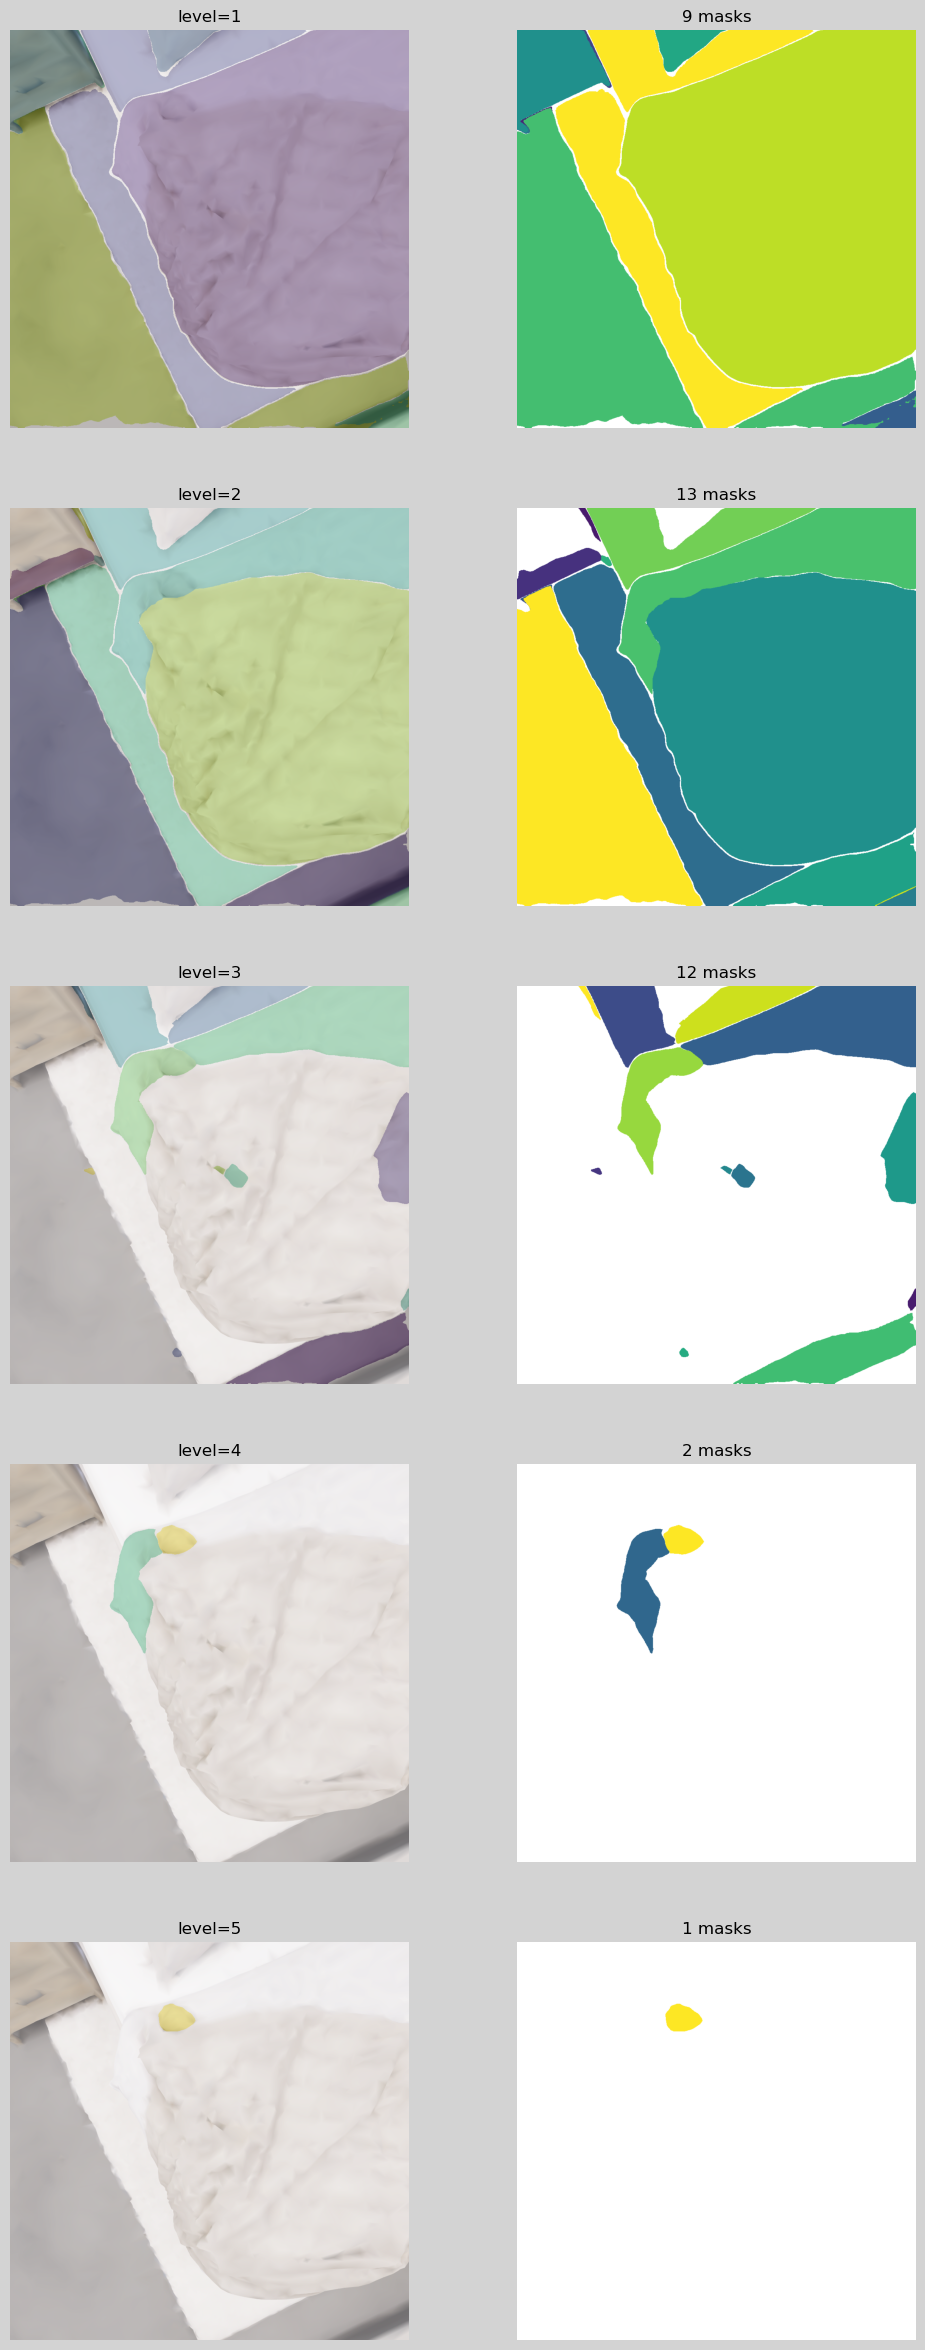

In [10]:
show_index = 0
image = images[show_index, :, :, :3]
print('image:', utils.show_shape(image))
tree_data = predictor.generate(
    (image.cpu().numpy() * 255).astype(np.uint8),
    max_iters=100,
    in_threshold=0.9,
    union_threshold=0.1,
    min_mask_region_area=100,
    points_per_update=256,
    device=device,
    in_thre_area=50,
)
ts.show_all_levels(image, tree_data, facecolor='lightgray', width=6)
print(utils.get_GPU_memory())
del tree_data
torch.cuda.empty_cache()
print(utils.get_GPU_memory())

In [11]:
# from rich.progress import track
from IPython.display import clear_output

for index in tqdm(range(N)):
    # if cache_dir.joinpath(f"view_{index:04d}.data").exists():
    #     continue
    tree_data = predictor.generate(
        (images[index, :, :, :3].cpu().numpy() * 255).astype(np.uint8),
        max_iters=100,
        in_threshold=0.9,
        union_threshold=0.1,
        min_mask_region_area=100,
        points_per_update=256,
        device=device,
        in_thre_area=50,
    )
    data = {
        'tree_data': tree_data.save(filename=None),
        'tri_id': tri_ids[index].clone(),
        'image': images[index].clone(),
        'Tw2v': Tw2vs[index].clone(),
    }
    torch.save(data, cache_dir.joinpath(f"view_{index:04d}.data"))

    clear_output(wait=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [40:52<00:00, 24.53s/it]


In [12]:
tree3d = Tree3Dv2(mesh, device=device, verbose=1)
# tree3d.load(cache_dir.joinpath('my.tree3dv2'))
tree3d.load_2d_results(cache_dir)

[Tree] reset
[Tree3D] GPU: (7.938991069793701, 11.904052734375)
[Tree3D] There are 100 data
[Tree3D] {'tree_data': {'masks': IntTensor[4, 1024, 1024], 'iou_preds': F16Tensor[35], 'area': LongTensor[35], 'parent': IntTensor[36], 'first': IntTensor[36], 'next': IntTensor[36], 'last': IntTensor[36], 'cnt': 35, 'num_samples': IntTensor[36], 'extra': {}}, 'tri_id': IntTensor[1024, 1024], 'image': F32Tensor[1024, 1024, 3], 'Tw2v': F32Tensor[4, 4]}
[Tree3D] GPU: (1.064974308013916, 11.904052734375)
[Tree3D] view_masks, view_infos[0]: F32Tensor[100, 100000], (IntTensor[7896], LongTensor[7896])
[Tree3D] loaded 100 views, 3871 masks, max_num: 200
[Tree3D] GPU: (5.209054470062256, 11.904052734375)


In [13]:
for k, v in tree3d.__dict__.items():
    if isinstance(v, Tensor):
        print(k, utils.show_shape(v), v.numel() * 1e-9, v.device)
    elif k == 'face_masks':
        print(k, sum(vi.numel() for vi in v) * 1e-9)
        # print(k, utils.show_shape(v))

area F32Tensor[99999] 9.9999e-05 cuda:0
parent IntTensor[1] 1e-09 cuda:0
first IntTensor[1] 1e-09 cuda:0
last IntTensor[1] 1e-09 cuda:0
next IntTensor[1] 1e-09 cuda:0
view_masks F32Tensor[100, 100000] 0.01 cuda:0
view_indices IntTensor[3871] 3.871e-06 cuda:0
face_masks F32Tensor[3871, 100000] 0.3871 cuda:0


In [14]:
tree3d.face_masks = tree3d.face_masks.cuda()
Gv = tree3d.build_view_graph()
Gm = tree3d.build_graph(Gv)
X, autoencoder = tree3d.compress_masks(epochs=5000)
print(autoencoder)
print(utils.get_GPU_memory())

[Tree3D] start build view graph
[Tree3D] start build graph
[Tree3D] X epoch[   0], loss: recon= 0.711, lr=1.000e-03
[Tree3D] X epoch[ 100], loss: recon= 0.136, lr=9.990e-04
[Tree3D] X epoch[ 200], loss: recon= 0.024, lr=9.960e-04
[Tree3D] X epoch[ 300], loss: recon= 0.021, lr=9.911e-04
[Tree3D] X epoch[ 400], loss: recon= 0.019, lr=9.842e-04
[Tree3D] X epoch[ 500], loss: recon= 0.014, lr=9.755e-04
[Tree3D] X epoch[ 600], loss: recon= 0.010, lr=9.648e-04
[Tree3D] X epoch[ 700], loss: recon= 0.008, lr=9.523e-04
[Tree3D] X epoch[ 800], loss: recon= 0.006, lr=9.381e-04
[Tree3D] X epoch[ 900], loss: recon= 0.005, lr=9.221e-04
[Tree3D] X epoch[1000], loss: recon= 0.005, lr=9.044e-04
[Tree3D] X epoch[1100], loss: recon= 0.004, lr=8.852e-04
[Tree3D] X epoch[1200], loss: recon= 0.004, lr=8.644e-04
[Tree3D] X epoch[1300], loss: recon= 0.004, lr=8.422e-04
[Tree3D] X epoch[1400], loss: recon= 0.003, lr=8.187e-04
[Tree3D] X epoch[1500], loss: recon= 0.003, lr=7.938e-04
[Tree3D] X epoch[1600], loss:

In [15]:
K = tree3d.Lmax * 2
gnn = pyg.nn.GCN(
    in_channels=X.shape[1],
    hidden_channels=128,
    num_layers=2,
    out_channels=K,
    norm='BatchNorm'
).cuda()
print(gnn)
tree3d.run(epochs=5000, K=K, gnn=gnn, A=Gm * Gm.ge(0.5), X=X)
tree3d.save(cache_dir.joinpath('my.tree3dv2'))

GCN(256, 400, num_layers=2)
[Tree3D] GPU: (4.245199203491211, 11.904052734375)
[Tree3D] GPU: (4.231782913208008, 11.904052734375)
[Tree3D] Epoch 100: loss=1.525198, match= 0.813, mm= 0.800
[Tree3D] Epoch 200: loss=1.309124, match= 0.585, mm= 0.666
[Tree3D] Epoch 300: loss=1.169696, match= 0.467, mm= 0.573
[Tree3D] Epoch 400: loss=1.204167, match= 0.404, mm= 0.518
[Tree3D] Epoch 500: loss=0.702040, match= 0.359, mm= 0.490
[Tree3D] Epoch 600: loss=0.556236, match= 0.314, mm= 0.456
[Tree3D] Epoch 700: loss=1.185521, match= 0.311, mm= 0.439
[Tree3D] Epoch 800: loss=0.377800, match= 0.297, mm= 0.431
[Tree3D] Epoch 900: loss=0.679591, match= 0.292, mm= 0.422
[Tree3D] Epoch 1000: loss=0.867350, match= 0.270, mm= 0.399
[Tree3D] Epoch 1100: loss=0.539156, match= 0.272, mm= 0.401
[Tree3D] Epoch 1200: loss=0.664736, match= 0.260, mm= 0.385
[Tree3D] Epoch 1300: loss=0.480867, match= 0.243, mm= 0.371
[Tree3D] Epoch 1400: loss=0.821935, match= 0.249, mm= 0.368
[Tree3D] Epoch 1500: loss=0.629104, mat

0: Tree Root
├── 263
├── 262
├── 261
├── 260
├── 259
├── 258
├── 257
├── 256
├── 255
├── 254
├── 253
├── 252
├── 251
├── 250
├── 249
├── 248
├── 247
├── 246
├── 245
├── 244
├── 243
├── 242
├── 241
├── 240
├── 239
├── 238
├── 237
├── 236
├── 235
├── 234
├── 233
├── 232
├── 231
├── 230
├── 229
├── 228
├── 227
├── 226
├── 225
├── 224
├── 223
├── 222
├── 221
├── 220
├── 219
├── 218
├── 217
├── 216
├── 215
├── 214
├── 213
├── 212
├── 211
├── 210
├── 209
├── 208
├── 207
├── 206
├── 205
├── 204
├── 203
├── 202
├── 201
├── 200
├── 199
├── 198
├── 197
├── 196
├── 195
├── 194
├── 193
├── 192
├── 191
├── 190
├── 189
├── 188
├── 187
├── 186
├── 185
├── 184
├── 183
├── 182
├── 181
├── 180
├── 179
├── 178
├── 177
├── 176
├── 175
├── 174
├── 173
├── 172
├── 171
├── 170
├── 169
├── 168
├── 167
├── 166
├── 165
├── 164
├── 163
├── 162
├── 161
├── 160
├── 159
├── 158
├── 157
├── 156
├── 155
├── 154
├── 153
├── 152
├── 151
├── 150
├── 149
├── 148
├── 147
├── 146
├── 145
├── 144
├── 143
├── 142
├── 141
├── 140
├── 139
├── 138
├── 137
├── 136
├── 135
├── 134
├── 133
├── 132
├── 131
├── 130
├── 129
├── 128
├── 127
├── 126
├── 125
├── 124
├── 123
├── 122
├── 121
├── 120
├── 119
├── 118
├── 117
├── 116
├── 115
├── 114
├── 113
├── 112
├── 111
├── 110
├── 109
├── 108
├── 107
├── 106
├── 105
├── 104
├── 103
├── 102
├── 101
├── 100
├── 99
├── 98
├── 97
├── 96
├── 95
├── 94
├── 93
├── 92
├── 91
├── 90
├── 89
├── 88
├── 87
├── 86
├── 85
├── 84
├── 83
├── 82
├── 81
├── 80
├── 79
├── 78
├── 77
├── 76
├── 75
├── 74
├── 73
├── 72
├── 71
├── 70
├── 69
├── 68
├── 67
├── 66
├── 65
├── 64
├── 63
├── 62
├── 61
├── 60
├── 59
├── 58
├── 57
├── 56
├── 55
├── 54
├── 53
├── 52
├── 51
├── 50
├── 49
├── 48
├── 47
├── 46
├── 45
├── 44
├── 43
├── 42
├── 41
├── 40
├── 39
├── 38
├── 37
├── 36
├── 35
├── 34
├── 33
├── 32
├── 31
├── 30
├── 29
├── 28
├── 27
├── 26
├── 25
├── 24
├── 23
├── 22
├── 21
├── 20
├── 19
├── 18
├── 17
├── 16
├── 15
├── 14
├── 13
├── 12
├── 11
├── 10
├── 9
├── 8
├── 7
├── 6
├── 5
├── 4
├── 3
├── 2
└── 1

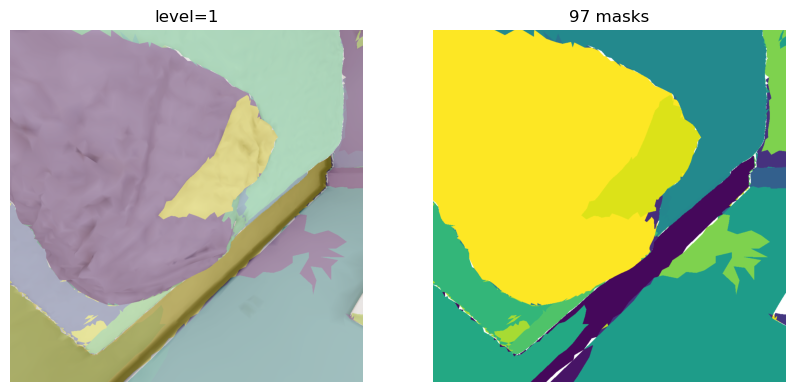

In [16]:
show_index = 8
ts.show_all_levels(images[show_index, :, :, :3], tree3d, tri_ids[show_index])
tree3d.print_tree()

In [17]:
# metric = ts.TreeSegmentMetric()
# metric.update(tree3d.to(device), gt_v2.to(device))
# print(metric.summarize(), metric.gt_iou_sum / metric.cnt)